# Building a CNN in TensorFlow with Keras for CIFAR10


## 1. Loading and inspecting the Dataset

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# dataset parameters
TRAIN_LENGTH = 50000
TRAIN_LENGTH = int(TRAIN_LENGTH*0.95)     # adjust for val_ds
VAL_LENGTH = 50000 - TRAIN_LENGTH
TEST_LENGTH = 10000
N_CLASSES = 10
imgW = 32
imgH = 32
imgD = 3

# input pipeline parameters
BUFFER_SIZE = 2048
BATCH_SIZE = 64
NUM_CORES = 4
PREFETCH_FACTOR = 1000

train_ds, test_ds = tfds.load('cifar10', 
                              split=['train', 'test'], 
                              as_supervised=True, 
                              shuffle_files=False)

val_ds = train_ds.skip(TRAIN_LENGTH).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.take(TRAIN_LENGTH).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


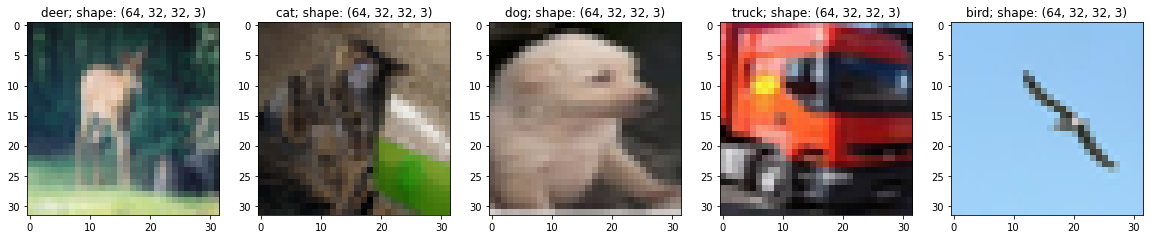

In [2]:
num_plots = 5
fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(20,4))
labelDic = {0: 'airplane', 
            1: 'automobile', 
            2: 'bird', 
            3: 'cat',
            4: 'deer',
            5: 'dog',
            6: 'frog',
            7: 'horse',
            8: 'ship',
            9: 'truck'}

# iterate over 5 batches and show the first image
for i, (img, label) in enumerate(val_ds.take(5)):
    label = labelDic[label.numpy()[0]]
    axes[i].imshow(img[0])
    axes[i].set_title(f'{label}; shape: {img.shape}')

## 2. Preprocessing the dataset
- one hot encoding of labels
- standardization of images

img: <dtype: 'float32'>, label: <dtype: 'float32'>


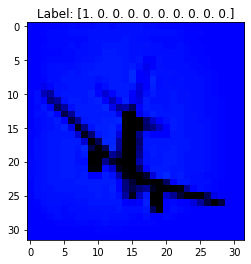

In [3]:
def randAugment(img):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.05)
        #img = tf.image.random_saturation(img, 0.6, 1.6)
        #img = tf.image.random_hue(img, 0.08)
        img = tf.image.random_contrast(img, 0.7, 1.3)
        return img
    
    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    return tf.cond(choice < 0.5, lambda: img, lambda: augment(img))

# casting of the images to float and one hot encoding of the labels
train_ds = train_ds.map(lambda img, label: (tf.cast(img, tf.float32)/255, tf.one_hot(label, depth=N_CLASSES)), 
                        num_parallel_calls=NUM_CORES)
val_ds = val_ds.map(lambda img, label: (tf.cast(img, tf.float32)/255, tf.one_hot(label, depth=N_CLASSES)),
                    num_parallel_calls=NUM_CORES)
test_ds = test_ds.map(lambda img, label: (tf.cast(img, tf.float32)/255, tf.one_hot(label, depth=N_CLASSES)),
                      num_parallel_calls=NUM_CORES)

# applying the image augemntation after we applied the .cache method, so the initial preprocessing 
# does not have to be redone (only works if data fits into memorry)
train_ds = train_ds.map(lambda img, label: (randAugment(img), label),
                        num_parallel_calls=NUM_CORES)

# standardizing the images
train_ds = train_ds.map(lambda img, label: (tf.image.per_image_standardization(img), label), 
                        num_parallel_calls=NUM_CORES)
val_ds = val_ds.map(lambda img, label: (tf.image.per_image_standardization(img), label), 
                        num_parallel_calls=NUM_CORES)
test_ds = test_ds.map(lambda img, label: (tf.image.per_image_standardization(img), label), 
                        num_parallel_calls=NUM_CORES)

# optimizing the datasets for the tensorflow pipeline
train_ds = train_ds.prefetch(int(TRAIN_LENGTH/BATCH_SIZE))
val_ds = val_ds.prefetch(int(VAL_LENGTH/BATCH_SIZE))
test_ds = test_ds.prefetch(int(TEST_LENGTH/BATCH_SIZE))

# for visualization purpose
for img, label in train_ds.take(1):
    print(f'img: {img.dtype}, label: {label.dtype}')
    plt.imshow(img[0])
    plt.title(f'Label: {label.numpy()[0]}')
    plt.show()
    break

## 3. The Model

In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, BatchNormalization, \
                            AveragePooling2D, Dense, Activation, Add, ReLU, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

class ResNet50_model(Model):
    """This Model serves to generate a fully convolutional network, that doesn't need reshaping
    of the images to be feeded into the network.

    Args:
        act: tf.keras.Layers()
            The activation function used.

    Returns:
        The ResNet_model.
    """
    
    def __init__(self, act, reg, inputShape=(32, 32, 3), classes=10, bnEps=2e-5, bnMom=0.9):
        super(ResNet50_model, self).__init__()
        
        # 1st stage
        # here we perform maxpooling, see the figure above

        self.conv_s1 = Conv2D(64, kernel_size=(2, 2), strides=(1, 1), padding='same')
        self.batch_s1 = BatchNormalization(epsilon=bnEps, momentum=bnMom)
        self.act_s1 = act()
        self.max_s1 = MaxPooling2D((8, 8), strides=(1, 1))
        
        #2nd stage 
        self.res_red_s2 = res_identity_dimRed(conFilter=64, regularizer=reg, activation=act, s=1)
        self.res_s2 = res_identity(conFilter=64, regularizer=reg, activation=act)
        #self.res_s22 = res_identity(conFilter=64, regularizer=reg, activation=act)

        # 3rd stage
        self.res_red_s3 = res_identity_dimRed(conFilter=128, regularizer=reg, activation=act, s=2)
        self.res_s3 = res_identity(conFilter=128, regularizer=reg, activation=act)
        self.res_s33 = res_identity(conFilter=128, regularizer=reg, activation=act)
        #self.res_s333 = res_identity(conFilter=128, regularizer=reg, activation=act)

        # 4th stage
        self.res_red_s4 = res_identity_dimRed(conFilter=256, regularizer=reg, activation=act, s=2)
        self.res_s4 = res_identity(conFilter=256, regularizer=reg, activation=act)
        self.res_s44 = res_identity(conFilter=256, regularizer=reg, activation=act)
        self.res_s444 = res_identity(conFilter=256, regularizer=reg, activation=act)
        #self.res_s4444 = res_identity(conFilter=256, regularizer=reg, activation=act)
        #self.res_s44444 = res_identity(conFilter=256, regularizer=reg, activation=act)

        # 5th stage
        self.res_red_s5 = res_identity_dimRed(conFilter=512, regularizer=reg, activation=act, s=2)
        self.res_s5 = res_identity(conFilter=512, regularizer=reg, activation=act)
        self.res_s55 = res_identity(conFilter=512, regularizer=reg, activation=act)

        # ends with average pooling and dense connection
        self.avg_out = GlobalAveragePooling2D()
        self.dense_out = Dense(256, activation='relu', 
                               kernel_regularizer=reg(0.0001),
                               kernel_initializer='he_normal')
        self.drop_out = Dropout(0.4)
        
        self.out = Dense(classes, activation='softmax', 
                         kernel_regularizer=reg(0.0001),
                         kernel_initializer='he_normal')
        
    def call(self, x, training):
        # 1st stage
        # here we perform maxpooling, see the figure above
        x = self.conv_s1(x)
        x = self.batch_s1(x, training=training)
        x = self.act_s1(x)
        x = self.max_s1(x)

        #2nd stage 
        x = self.res_red_s2(x, training)
        x = self.res_s2(x, training)
        #x = self.res_s22(x, training)

        # 3rd stage
        x = self.res_red_s3(x, training)
        x = self.res_s3(x, training)
        x = self.res_s33(x, training)
        #x = self.res_s333(x, training)

        # 4th stage
        x = self.res_red_s4(x, training)
        x = self.res_s4(x, training)
        x = self.res_s44(x, training)
        x = self.res_s444(x, training)
        #x = self.res_s4444(x, training)
        #x = self.res_s44444(x, training)

        # 5th stage
        x = self.res_red_s5(x, training)
        x = self.res_s5(x, training)
        x = self.res_s55(x, training)
        
        # ends with average pooling and dense connection
        x = self.avg_out(x)
        x = self.dense_out(x)
        x = self.drop_out(x, training=training)
        x = self.out(x)

        return x

class res_identity(tf.keras.layers.Layer):
    def __init__(self, conFilter, regularizer, activation, r_value=0.0001, bnEps=2e-5, bnMom=0.9):
        super(res_identity, self).__init__()
        convFilter2 = conFilter*3

        #first block 
        self.conv_b1 = Conv2D(conFilter, 
                               kernel_size=(1, 1), 
                               strides=(1, 1), 
                               padding='valid', 
                               kernel_regularizer=regularizer(r_value))
        self.batch_b1 = BatchNormalization(epsilon=bnEps, momentum=bnMom)
        self.act_b1 = activation()

        #second block # bottleneck (but size kept same with padding)
        self.conv_b2 = Conv2D(conFilter, 
                               kernel_size=(3, 3), 
                               strides=(1, 1), 
                               padding='same', 
                               kernel_regularizer=regularizer(r_value))
        self.batch_b2 = BatchNormalization(epsilon=bnEps, momentum=bnMom)
        self.act_b2 = activation()

        # third block activation used after adding the input
        self.conv_b3 = Conv2D(convFilter2, 
                               kernel_size=(1, 1), 
                               strides=(1, 1), 
                               padding='valid', 
                               kernel_regularizer=regularizer(r_value))
        self.act_b3 = BatchNormalization(epsilon=bnEps, momentum=bnMom)
        self.add = Add() # add the input
        self.act = activation()

    def call(self, x, training):
        x_res = x

        x = self.conv_b1(x)
        x = self.batch_b1(x, training=training)
        x = self.act_b1(x, training=training)

        #second block # bottleneck (but size kept same with padding)
        x = self.conv_b2(x)
        x = self.batch_b2(x, training=training)
        x = self.act_b2(x)

        # third block activation used after adding the input
        x = self.conv_b3(x)
        x = self.act_b3(x)
        x = self.add([x, x_res])   # add the input 
        x = self.act(x)
        
        return x
            
class res_identity_dimRed(tf.keras.layers.Layer):
    def __init__(self, conFilter, regularizer, activation, s=1, r_value=0.0001, bnEps=2e-5, bnMom=0.9):
        super(res_identity_dimRed, self).__init__()
        conFilter2 = conFilter * 3

        # first block
        # when s = 2 then it is like downsizing the feature map
        self.conv_b1 = Conv2D(conFilter, 
                              kernel_size=(1, 1), 
                              strides=(s, s), 
                              padding='valid', 
                              kernel_regularizer=regularizer(r_value))
        self.batch_b1 = BatchNormalization(epsilon=bnEps, momentum=bnMom)
        self.act_b1 = activation()

        # second block
        self.conv_b2 = Conv2D(conFilter, 
                              kernel_size=(3, 3), 
                              strides=(1, 1), 
                              padding='same', 
                              kernel_regularizer=regularizer(r_value))
        self.batch_b2 = BatchNormalization(epsilon=bnEps, momentum=bnMom)
        self.act_b2 = activation()

        #third block
        self.conv_b3 = Conv2D(conFilter2, 
                              kernel_size=(1, 1), 
                              strides=(1, 1), 
                              padding='valid', 
                              kernel_regularizer=regularizer(r_value))
        self.batch_b3 = BatchNormalization(epsilon=bnEps, momentum=bnMom)

        # shortcut 
        self.conv_res = Conv2D(conFilter2, 
                               kernel_size=(1, 1), 
                               strides=(s, s), 
                               padding='valid', 
                               kernel_regularizer=regularizer(r_value))
        self.batch_res = BatchNormalization(epsilon=bnEps, momentum=bnMom)

        # add 
        self.add = Add()
        self.act = activation()
    
    def call(self, x, training):
        x_res = x
        
        # first block
        x = self.conv_b1(x)
        x = self.batch_b1(x, training=training)
        x = self.act_b1(x)

        # second block
        x = self.conv_b2(x)
        x = self.batch_b2(x, training=training)
        x = self.act_b2(x)

        #third block
        x = self.conv_b3(x)
        x = self.batch_b3(x, training=training)

        # shortcut 
        x_res = self.conv_res(x_res)
        x_res = self.batch_res(x_res, training=training)

        # add 
        x = self.add([x, x_res])
        x = self.act(x)      
        
        return x

## 4. Training and evaluation of the Model based on the Malaria dataset

In [5]:
class Timer():
    """
    A small class for making timings.
    """
    def __init__(self):
        self._start_time = None

    def start(self):
        """
        Start a new timer
        """
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """
        Stop the timer, and report the elapsed time
        """
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        return elapsed_time     


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, stepSize):
        super(CustomSchedule, self).__init__()
        self.stepsPerEpoch = stepSize
    
    @tf.function
    def __call__(self, step):
        step = (step+1) / self.stepsPerEpoch
        lr = 0.005
        if step >= 20:
            lr = 0.000
        elif step >= 15:
            lr = 0.000005
        elif step >= 10:
            lr = 0.00005
        elif step >= 5:
            lr = 0.0005

        return lr
    
@tf.function
def train_step(model, train_ds, loss_function, optimizer, train_loss_metric, train_acc_metric):
    '''
    Training loop.
    '''
    for img, target in train_ds:   # takes wUpdates amount of batches from an infinit dataset (repeats itself)    
        # forward pass with GradientTape
        with tf.GradientTape() as tape:
            prediction = model(img, training=True)
            loss = loss_function(target, prediction)
            loss_reg = loss + tf.reduce_sum(model.losses)

        # backward pass via GradienTape (auto-gradient calc)
        gradients = tape.gradient(loss_reg, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # calculate metrics
        train_loss_metric.update_state(loss)
        train_acc_metric.update_state(target, prediction)

@tf.function
def eval_step(model, ds, loss_function, loss_metric, acc_metric):
    '''
    Evaluation Loop.
    '''
    for img, target in ds:
        # forward pass
        prediction = model(img, training=False)
        # calculate metrics
        loss = loss_function(target, prediction)
        loss_metric.update_state(loss)
        acc_metric.update_state(target, prediction)

In [6]:
import datetime 

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
val_log_dir = 'logs/gradient_tape/' + current_time + '/val'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

In [7]:
timer = Timer()
tf.keras.backend.clear_session()
tf.random.set_seed(25)

# Hyperparameter
EPOCHS = 1
#LEARNING_RATE = 5e-4
LEARNING_RATE = CustomSchedule(stepSize=742)

# Initialize the model.
model = ResNet50_model(act=ReLU, reg=l2, inputShape=(32, 32, 3), classes=10)

# take one example to see if the model works and print the model summary
for (img, label) in train_ds.take(1):
    model(img)
    model.summary()

# initialize model loss and optimizer
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# prepare metrics
train_acc_metric = tf.keras.metrics.CategoricalAccuracy('train_accuracy')
val_acc_metric = tf.keras.metrics.CategoricalAccuracy('val_accuracy')
test_acc_metric = tf.keras.metrics.CategoricalAccuracy('test_accuracy')

train_loss_metric = tf.keras.metrics.Mean('train_loss')
val_loss_metric = tf.keras.metrics.Mean('val_loss')
test_loss_metric = tf.keras.metrics.Mean('test_loss')

# initialize metric lists for later visualization.
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []
times = []

print(f'[INFO] - Evaluating the Dataset on the {model.name} before training.')
timer.start()

# on train_ds
eval_step(model, train_ds, loss_function, 
          loss_metric=train_loss_metric, 
          acc_metric=train_acc_metric)

train_loss = train_loss_metric.result()
train_acc = train_acc_metric.result()
train_losses.append(train_loss)
train_accuracies.append(train_acc)

# on eval_ds
eval_step(model, val_ds, loss_function, 
          loss_metric=val_loss_metric, 
          acc_metric=val_acc_metric)

val_loss = val_loss_metric.result()
val_acc = val_acc_metric.result()
val_losses.append(val_loss)
val_accuracies.append(val_acc)

elapsed_time = timer.stop()
times.append(elapsed_time)

print(f'train_loss: {train_loss:0.4f}, train_acc: {train_acc:0.4f}, val_loss: {val_loss:0.4f}, val_acc: {val_acc:0.4f}')

for epoch in range(EPOCHS):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    timer.start()

    train_step(model, train_ds, loss_function, optimizer, train_loss_metric, train_acc_metric)

    elapsed_time = timer.stop()
    times.append(elapsed_time)

    # Evaluating training metrics
    train_loss = train_loss_metric.result()
    train_acc = train_acc_metric.result()
    
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step=epoch)
        tf.summary.scalar('accuracy', train_acc, step=epoch)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {train_loss:0.4f}, train_acc: {train_acc:0.4f}')
    
    # Evaluation of the model
    timer.start()

    eval_step(model, val_ds, loss_function, 
              loss_metric=val_loss_metric, 
              acc_metric=val_acc_metric)

    # Evaluating validation metrics
    val_loss = val_loss_metric.result()
    val_acc = val_acc_metric.result()
    
    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step=epoch)
        tf.summary.scalar('accuracy', val_acc, step=epoch)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f'[{epoch}] - Finished evaluation - val_loss: {val_loss:0.4f}, val_accuracy: {val_acc:0.4f}')
    
    # Resetting train and validation metrics
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()
    train_loss_metric.reset_states()
    val_loss_metric.reset_states()
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)
    
    if epoch%1 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(EPOCHS-epoch-1)/60:0.4f} min.')

# Testing the model
timer.start()

eval_step(model, test_ds, loss_function, 
          loss_metric=test_loss_metric, 
          acc_metric=test_acc_metric)

elapsed_time = timer.stop()
times.append(elapsed_time)

# Evaluating test metrics
test_loss = test_loss_metric.result()
test_acc = test_acc_metric.result()
test_losses.append(test_loss)
test_accuracies.append(test_acc)
print(f'[INFO] - Finished testing of the {model.name} - test_loss: {test_loss:0.4f}, test_accurac: {test_acc:0.4f}')
print(f'[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

Model: "res_net50_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  832       
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
res_identity_dim_red (res_id multiple                  68096     
_________________________________________________________________
res_identity (res_identity)  multiple                  63040     
_________________________________________________________________
res_identity_dim_red_1 (res_ multiple              

/home/janosch/.virtualenvs/TF/lib/python3.6/site-packages/tensorflow/python/autograph/operators/control_flow.py:684: UserWarning: Seed 25 from outer graph might be getting used by function tf_data_experimental_scan_scan_body, if the random op has not been provided any seed. Explicitly set the seed in the function if this is not the intended behavior.
  ds = _general_purpose_scan(ds, init_vars, scan_body)


[0] - Finished Epoch in 170.95 seconds - train_loss: 2.1539, train_acc: 0.1686
[0] - Finished evaluation - val_loss: 2.0477, val_accuracy: 0.1947

[INFO] - Total time elapsed: 3.3182 min. Total time remaining: 0.0000 min.
[INFO] - Finished testing of the res_net50_model - test_loss: 1.8042, test_accurac: 0.2787
[INFO] - Total run time: 3.4089 min.


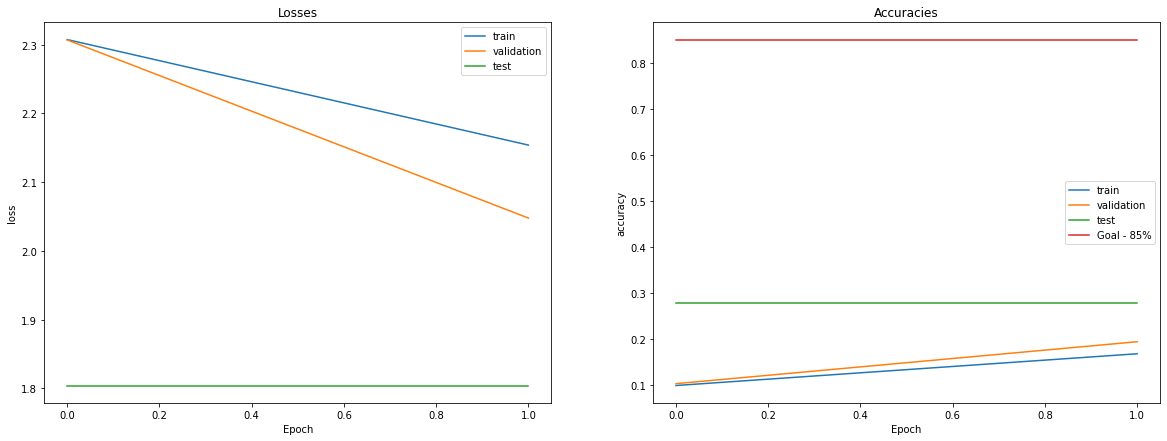

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

x = np.arange(len(train_losses))

# losses
axes[0].plot(x, train_losses, label='train')
axes[0].plot(x, val_losses, label='validation')
axes[0].plot([test_losses for _ in range(len(train_losses))], label='test')
axes[0].legend()
axes[0].set(title='Losses', xlabel='Epoch', ylabel='loss')

# accuracies
axes[1].plot(x, train_accuracies, label='train')
axes[1].plot(x, val_accuracies, label='validation')
axes[1].plot([test_accuracies for _ in range(len(train_accuracies))], label='test')
axes[1].plot([0.85 for _ in range(len(val_accuracies))], label='Goal - 85%')
axes[1].legend()
axes[1].set(title='Accuracies', xlabel='Epoch', ylabel='accuracy')

plt.show()

In [11]:
%load_ext tensorboard
%tensorboard --logdir logs/gradient_tape

ModuleNotFoundError: No module named 'tensorboard --logdir logs/gradient_tape'